## H ランダムフォレスト回帰による予測タスク

### 荻窪の家賃予測タスク
**ポイント** ランダムフォレスト回帰のハイパーパラメータの選択の重要性を確認しましょう。

#### データを読み込もう

In [1]:
# データの読み込み
import pandas as pd
filepath_train = "./data/ogikubo_oneroom_train.csv"
oneroom_train = pd.read_csv(filepath_or_buffer = filepath_train)
oneroom_train.head(n = 5)

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
1,メゾン・ド・荻窪,4.5,12.11,40,7,0,0
2,ＪＲ中央線 荻窪駅 3階建 築40年,4.5,12.11,40,6,0,0
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1
4,グローリア初穂阿佐ヶ谷,6.0,16.65,31,15,0,1


In [2]:
# データの次元
oneroom_train.shape

(100, 7)

#### 荻窪の家賃予測タスクの説明
前節にPythonで読み込んだデータですが、これは荻窪のワンルームマンションの物件に関する情報を収集してきた実データです。次のような変数をレコードしてきました。
* name : 物件名
* value : 家賃[万円]
* area : 面積[m²]
* age : 築年数[年]（注 : 新築の場合0年）
* distance : 最寄り駅（JR中央線荻窪駅）まで徒歩でかかる時間[分]
* bath_toilet_separated : バス・トイレ別（1 : True, 0 : False）
* autolock : オートロック（1 : True, 0 : False ）

今回は「荻窪のワンルームマンションの家賃を他の物件情報を用いて予測できるようにしよう」というタスクにランダムフォレスト回帰で挑戦してみたいと思います。

#### データの可視化と数値要約

#### 散布図 : 家賃とその他の変数との関係性
家賃を予測する上で必要そうな変数はなにかを絞るために、散布図に注目しましょう。

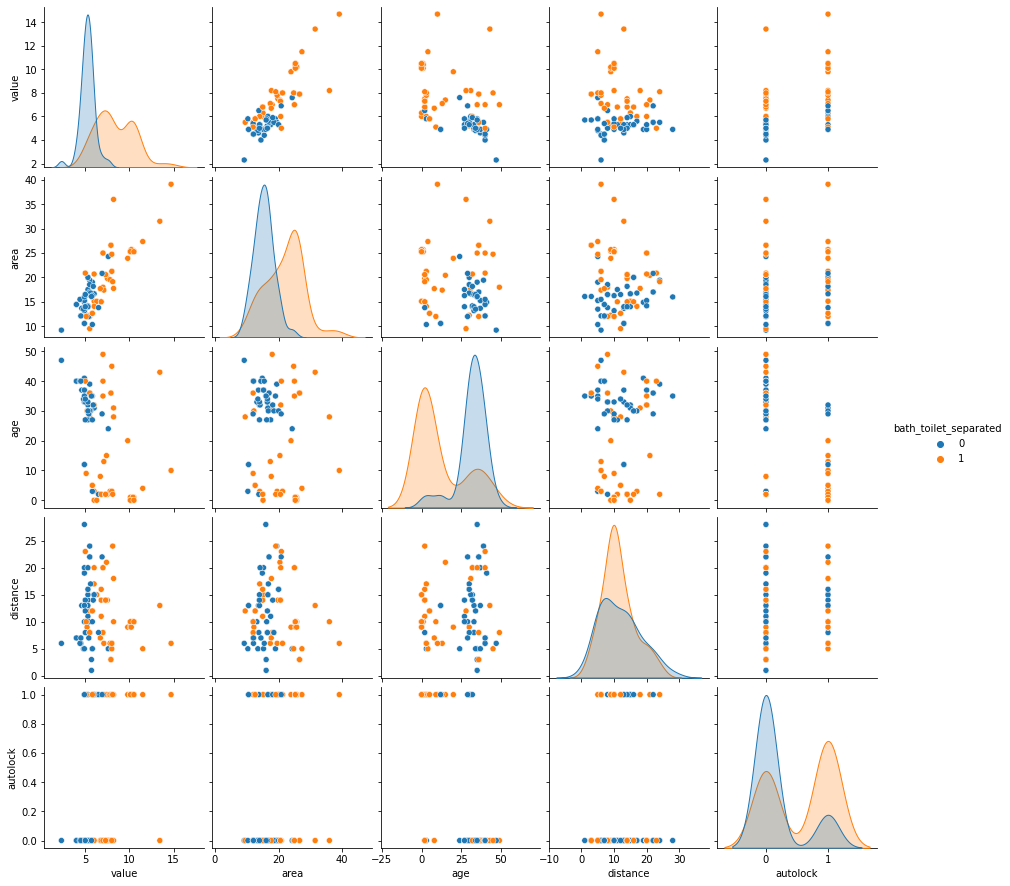

In [3]:
# データの可視化
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(oneroom_train, hue = "bath_toilet_separated")
plt.show()

#### 特徴量選択とモデルの選択
ここでは、ランダムフォレスト回帰のハイパーパラメータ
* n_estimators
* max_leaf_nodes

を探索します。

In [4]:
# 特徴量選択
feature_name = ["area", "age", "bath_toilet_separated", "autolock"]
X_train = oneroom_train[feature_name].values
y_train = oneroom_train["value"].values

《スクリプトの説明》
* 1行目 : 散布図を参考に選択した特徴量のリストを作ります。
* 2行目 : データから特徴量として選択した列のみを抽出し、`numpy.2darray`の形で取得します。
* 3行目 : データから予測したい変数`value`を抽出し、`numpy.1darray`の形で取得します。

In [5]:
# ハイパーパラメータを選択するためのデータの分割（演習）
from sklearn.model_selection import train_test_split
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train,
                                                  random_state = 1)

In [6]:
# random forest回帰で回帰モデルを作る。（演習）
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 1000,
                              max_leaf_nodes = 40,
                              min_samples_leaf = 10,
                              random_state = 1)
model.fit(X_learn, y_learn)

RandomForestRegressor(max_leaf_nodes=40, min_samples_leaf=10, n_estimators=1000,
                      random_state=1)

《スクリプトの説明》
* 1行目 : 機械学習モデル周りをサポートしている`sklearn`パッケージの`ensemble`モジュールから`RandomForestRegressor`クラスをimportします。
* 2行目 : ランダムフォレスト回帰のハイパーパラメータを設定します。
    - `n_estimators` : 弱学習器の個数
    - `max_features` : ノードの分割に使う入力変数の最大数（今回は指定しない。）
    - 決定木回帰のハイパーパラメータ
        - `max_leaf_nodes` : 葉ノードの最大数
        - `min_sample_leaves` : 葉ノードに属する訓練データ点の最小数（今回は指定しない。）
* 3行目 : 特徴量のデータ`X_learn`と予測したい変数のデータ`y_learn`を与えて、予測モデルを作成します。

`max_features`を指定しなかったので、各弱学習器では各ノードの学習時にすべての入力変数が用いられます。また、`min_sample_leaves`を指定しなかったので、訓練データ点が1つしか属さないような分割領域が学習されることもありますが、簡単のためこの辺りの細かいチューニングは行わないことにしました。なお、`RandomForestRegressor` classの`random_state`引数は、bootstrap標本の抽出と弱学習器である`DecisionTreeRegressor`を学習する際のシード値を決めているものです。

In [7]:
# 予測値の計算（演習）
pred_val = model.predict(X_val)

In [8]:
# 正答率の計算（演習）
from sklearn.metrics import r2_score
r2_score(y_val, pred_val)

0.9427155542918567

In [9]:
# 補足 : GridSearchCV
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 1)
param_grid = {"max_leaf_nodes" : [10, 20, 30, 40, 50]}
model = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5, scoring = "r2", n_jobs = -1)
model.fit(X_train, y_train)
model.best_params_

{'max_leaf_nodes': 40}

#### モデルの評価
さて、あと一息です。予測モデルを作成したら、そのモデルの良さを評価しましょう。モデルの良さには2つの軸
* 学習に用いたデータをどれくらい学習できたか。
* 未知のデータに対してどれだけ精度よく予測できるか。

があることを見ていきます。

#### モデルの学習

In [10]:
# modelの学習（演習）
model = RandomForestRegressor(n_estimators = 100,
                              max_leaf_nodes = 1024,
                              random_state = 1)
model.fit(X_train, y_train)

RandomForestRegressor(max_leaf_nodes=1024, random_state=1)

#### 学習に用いたデータにおけるモデルの評価
予測モデルを評価するときに役に立つものとして、**決定係数**と**残差プロット**があります。決定係数は数値的な評価指標で、予測と実際の値がばっちり一致していたら1.0となり、食い違うほどどんどん低い値になります。また、負の数になることもあります。残差プロットは予測値を横軸、残差（= 実測値と予測値の差）を縦軸にしてプロットしたグラフのことで、残差の規模感を実際の予測変数の規模感と比較して「精度」を評価するのに役立ちます。

In [11]:
# 決定係数によるモデルの評価
from sklearn.metrics import r2_score
pred_train = model.predict(X_train)
r2_score(y_true = y_train, y_pred = pred_train)

0.9767703857738474

《スクリプトの説明》
* 1行目 : `sklearn`パッケージの`metrics`モジュールから`r2_score`メソッドをimportします。
* 2行目 : 学習に用いた特徴量のデータから`value`変数の予測値を計算します。
* 3行目 : `r2_score`メソッドで決定係数を計算します。
    - `y_true`引数 : 実際の値
    - `y_pred`引数 : 予測モデルから計算できる予測値

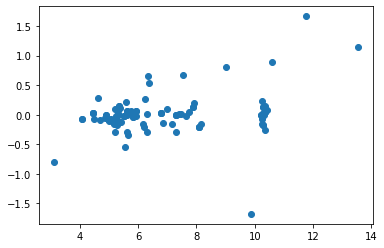

In [12]:
# 残差プロット
import matplotlib.pyplot as plt
error_train = y_train - pred_train
plt.scatter(pred_train, error_train)
plt.show()

《考察》

決定係数が1.0に近いことから、データを良く学習できていることが見て取れます。また、残差プロットから予測値が13万円になるまでは、残差が±1万円程度に収まっており、予測した`value`変数の規模感（2.5万円-15.0万円）と見比べてみても、残差が小さめであることが見て取れます。ただし、予測値として13万円以上を返す際には、1.5万円と大きく予測が外れるケースが見受けられ、13万円以上の予測値を得た場合に信頼できるかは注意が必要であろうことも見て取れるでしょう。

#### 未知のデータにおけるモデルの評価
予測モデルは、実はその学習の仕組みから、学習したデータに対する予測精度は可能な限り高くなるようになっていることが分かります。ここで注意を払いたいのは、本来「予測の精度」とは新しく入ってきたデータに対しても、上手く予測できることを指すという点です。要するに、学習したデータを用いたモデルの評価は、学習が上手く進んでいたかを確認する指標にはなっても、予測の精度を評価する指標にはなりません。そこで、機械学習では、事前に学習に使わないデータを別に作っておいて、精度評価のためだけに用いるということを行います。

In [13]:
# 未知データの読み込み
import pandas as pd
filepath_test = "./data/ogikubo_oneroom_test.csv"
oneroom_test = pd.read_csv(filepath_or_buffer = filepath_test)
oneroom_test = oneroom_test.drop_duplicates()
oneroom_test.shape

(61, 7)

In [14]:
# 未知データの入力と出力を作る。
X_test = oneroom_test[feature_name].values
y_test = oneroom_test["value"].values

In [15]:
# 未知データに対する決定係数
from sklearn.metrics import r2_score
pred_test = model.predict(X_test)
r2_score(y_test, pred_test)

0.9130658325841368

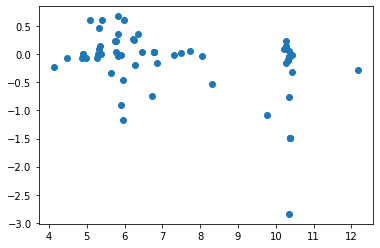

In [16]:
# 残差プロット
import matplotlib.pyplot as plt
error_test = y_test - pred_test
plt.scatter(pred_test, error_test)
plt.show()

《考察》

未知のデータに対しても決定係数は1.0に近い値をとっていることから、予測モデルの精度は高いことが見て取れます。特に残差プロットからも、予測値が13万円になるまでは、残差がおよそ±1万円程度に収まっており、予測した`value`変数の規模感（2.5万円-15.0万円）と見比べてみても、残差が小さめであることが見て取れます。

#### 変数重要度
その変数を用いて、出力の平均値で予測を決めるよりもどれだけ残差の2乗和を減らすことが出来たかを表す指標が変数重要度です。`sklearn`では、変数重要度は合計して1.0になるように正規化されて出力されます。

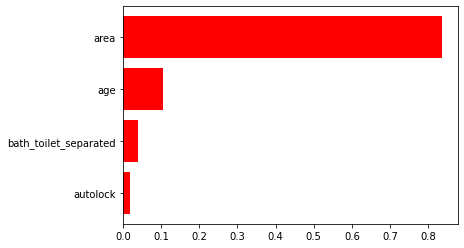

In [17]:
import numpy as np
importances = model.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

In [18]:
model.feature_importances_

array([0.83512419, 0.10652093, 0.03857135, 0.01978352])